# Problem set #1
#### by Cooper Nederhood

## Question (1):

In [1]:
# Load libraries
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib.ticker import MultipleLocator

In [2]:
# Define a function for generating the income over time
def income_simulation(sim_prof):
    '''
    Input: 
        sim_prof: (dict) containing simulations specs

    sim_prof = {
        sigma       : 0.1
        rho         : 0.2
        g           : 0.03
        inc0        : 80000
        iterations  : 10000
        years       : 40
    }
    '''
    SEED = 1348029

    sigma = sim_prof['sigma']
    years = sim_prof['years']
    iterations = sim_prof['iterations']
    inc0 = sim_prof['inc0']
    rho = sim_prof['rho']
    g = sim_prof['g']

    # set seed
    np.random.seed(SEED)

    # generate random wealth shocks
    wealth_shocks = np.random.normal(0, sigma, (years, iterations))

    # create max for wealth
    ln_wealth_mat = np.zeros( (years, iterations))

    # initialize first row in the matrix
    ln_wealth_mat[0, :] = np.log(inc0) + wealth_shocks[0, :]

    # Iterate from t=1 to end (t = 39):
    for t in range(1,ln_wealth_mat.shape[0]):
        ln_wealth_mat[t, :] = (1 - rho)*(np.log(inc0) + g*t) + rho*ln_wealth_mat[t-1, :] + wealth_shocks[t,:]

    wealth_mat = np.exp(ln_wealth_mat)

    return wealth_mat



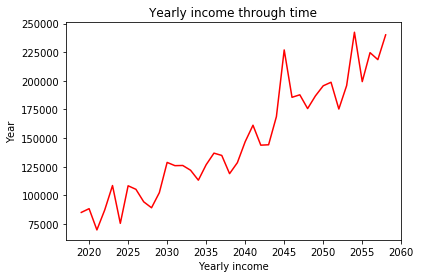

In [3]:
# Call the function using our given parameters
cur_sim = {'sigma': 0.1, 'rho': 0.2, 'g': 0.03, 'inc0': 80000, 'iterations': 10000, 'years': 40}
wealth_mat = income_simulation(cur_sim)

# save out an iteration to graph
iteration0 = wealth_mat[:, 0]

# Plot iteration0
plt.plot(list(range(2019, 2019 + cur_sim['years'])), iteration0, "r-")
plt.title('Yearly income through time')
plt.xlabel('Yearly income')
plt.ylabel('Year')

plt.show()


## Question (2):

In [4]:
# What percentage has initial income of less than $70K, more than $100K
income_0 = wealth_mat[0,:]
over_100k = income_0[income_0 > 100000]
less_70k = income_0[income_0 < 70000]

print("{}% has initial income > $100,000".format(100*len(over_100k) / cur_sim['iterations']))
print("{}% has initial income < $70,000".format(100*len(less_70k) / cur_sim['iterations']))

1.42% has initial income > $100,000
9.06% has initial income < $70,000


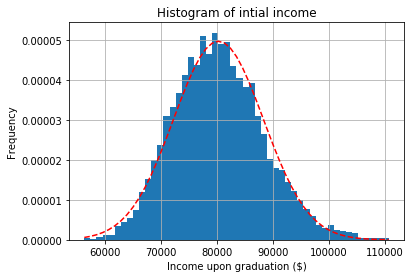

In [5]:
# Plot histogram of initial income
n, bins, patches = plt.hist(income_0, 50, normed = 1)
plt.ylabel("Frequency")
plt.xlabel("Income upon graduation ($)")
plt.title("Histogram of intial income")
plt.grid(True)
y = mlab.normpdf(bins, np.mean(income_0), np.std(income_0) )
l = plt.plot(bins, y , 'r--')
plt.show()


Answer: Yes, the distribution appears normal although perhaps it is just a hair skewed but this could just be random variation.


## Question (3):

In [30]:
# define a function for calculating debt payment thru time
def debt_payoff(wealth_mat, init_debt, payoff_rate):
    '''
    Given an income matrix and debt paramaters, returns matrix of debt over time
    Inputs:
        wealth_mat: (np array) matrix of yearly income
        init_debt: initial debt amount (positive number denotes debt)
        payoff_rate: [0,1] fraction of yearly income allocated to debt payoff
    
    Returns: debt_matrix
    '''

    debt_matrix = np.zeros((wealth_mat.shape[0], wealth_mat.shape[1]))

    # Calculate debt at end of first year (debt cannot go below $0)
    debt_matrix[0, :] = np.maximum(init_debt - wealth_mat[0, :] * payoff_rate, 0)

    # Calcualte debt at all other years
    for t in range(1, wealth_mat.shape[0]):
        debt_matrix[t, :] = np.maximum(debt_matrix[t-1, :] - wealth_mat[t, :] * payoff_rate, 0)

    return debt_matrix

In [31]:
def find_first_zeros(matrix):
    '''
    Given a matrix of floats, returns a list of the index
    with the first zero
    Notes:
        - finds first zero by column
    '''

    # if n periods of payment are nonzero, then the first time with zero
    #   debt is n+1
    first_zero_list = []
    for j in range(0, matrix.shape[1]):
        cur_col = matrix[:, j]
        non_zero_count = np.count_nonzero(cur_col)
        t_no_debt = non_zero_count + 1

        first_zero_list.append(t_no_debt)

    return first_zero_list

In [36]:
# Create our debt matrix thru time
debt_matrix = debt_payoff(wealth_mat, 95000, .1)

# Find first zeros thru time
first_zero_list = find_first_zeros(debt_matrix)

In [44]:
# Example of one payoff stream
print("The first debtor pays has zero debt at the end of year {}. Their end of year debt looks like:".format(first_zero_list[0]))
print(debt_matrix[:first_zero_list[0], 1])

The first debtor pays has zero debt at the end of year 11. Their end of year debt looks like:
[ 86987.60960265  77662.9809972   67954.73381688  58802.32077577
  48426.2264954   38267.18294803  29278.13994651  20215.30129479
  10080.846747     1165.8300879       0.        ]


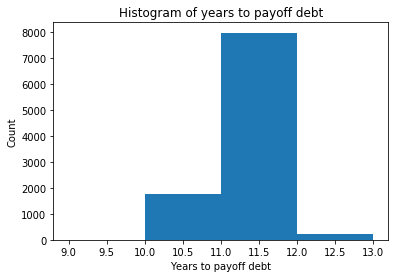

In [67]:
# Create histogram of payoff
first_zero_set = set(first_zero_list)
xbins = sorted(list(first_zero_set))
xbins.append(xbins[-1]+1)
n, bins, patches = plt.hist(first_zero_list, list(xbins))
plt.xlabel("Years to payoff debt")
plt.ylabel("Count")
plt.title("Histogram of years to payoff debt")
plt.show()

In [63]:
# Run quick check on the above histogram check
counter = {}
for x in first_zero_list:
    counter[x] = counter.get(x,0) + 1
print(counter)

{11: 7981, 12: 236, 10: 1782, 9: 1}


In [71]:
# How many people have zero debt in t = 9, ie year == 2028
def pct_no_debt(debt_mat, t):
    '''
    Simple function to calc % of people with zero debt in time t (indexed at 0)
    '''
    with_debt = np.count_nonzero(debt_mat[t , :])
    
    pct_no_debt = 1 - with_debt/debt_mat.shape[1]
    
    return pct_no_debt

In [78]:
# Call debt % function
t = 9
pct = pct_no_debt(debt_matrix, t)
print("{}% of people have no debt as of year {}".format(pct*100, 2019 + t))

17.830000000000002% of people have no debt as of year 2028


## Question (4):

In [79]:
# Set inc0 = 85000 and sigma = 0.15
cur_sim2 = {'sigma': 0.15, 'rho': 0.2, 'g': 0.03, 'inc0': 85000, 'iterations': 10000, 'years': 40}
wealth_mat2 = income_simulation(cur_sim2)

# Create our debt matrix thru time
debt_matrix2 = debt_payoff(wealth_mat2, 95000, .1)

# Find first zeros thru time
first_zero_list2 = find_first_zeros(debt_matrix2)


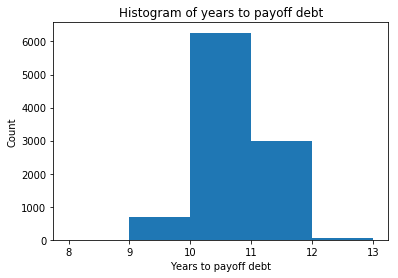

In [81]:
# Recreate histogram of payoff
first_zero_set2 = set(first_zero_list2)
xbins2 = sorted(list(first_zero_set2))
xbins2.append(xbins2[-1]+1)
n, bins, patches = plt.hist(first_zero_list2, list(xbins2))
plt.xlabel("Years to payoff debt")
plt.ylabel("Count")
plt.title("Histogram of years to payoff debt")
plt.show()

In [82]:
# Run quick check on the above histogram check
counter = {}
for x in first_zero_list2:
    counter[x] = counter.get(x,0) + 1
print(counter)

{10: 6264, 11: 2988, 9: 681, 12: 63, 8: 4}


In [83]:
# Call debt % function
t = 9
pct = pct_no_debt(debt_matrix2, t)
print("{}% of people have no debt as of year {}".format(pct*100, 2019 + t))

69.49000000000001% of people have no debt as of year 2028


##### End of assignment